# Customer Churn Prediction 

The goal of this project is to predict whether a customer will leave the service 
(churn = 1) or stay (churn = 0), and to understand why customers leave.

This notebook covers a full data science workflow:
- exploratory data analysis (EDA)
- model training and evaluation
- model explainability
- simple business impact analysis

The results are used to support business decisions 
and targeted customer retention actions.


## Data Loading

In this section, we load the prepared dataset and do a quick sanity check
(shape, preview, and churn ratio).


In [1]:
import pandas as pd

df = pd.read_json("customer_data.json")  
print(df.shape)
print(df.head())
print(df["churn"].value_counts(normalize=True))


(1400, 15)
  customer_id  churn  tenure  monthly_charges  total_charges   contract_type  \
0       C0001      0      48            14.16         677.33             2yr   
1       C0002      0      28            29.47         829.68  month-to-month   
2       C0003      0      10            91.24         899.42  month-to-month   
3       C0004      0      21            28.94         619.50             1yr   
4       C0005      0      18            28.00         447.22  month-to-month   

  payment_method  promo_active  support_tickets  auto_renew  last_login_days  \
0    credit_card             0                0           1               36   
1  bank_transfer             0                0           1               32   
2    credit_card             0                0           1               22   
3           cash             0                2           1               28   
4  bank_transfer             0                0           0               39   

  usage_level  complaints  

The dataset loads successfully and the churn rate looks reasonable for modeling.

## Exploratory Data Analysis (EDA)

In this section, we explore the data to understand churn
and identify differences between customers who stay and who leave.


Chart: Churn Ratio

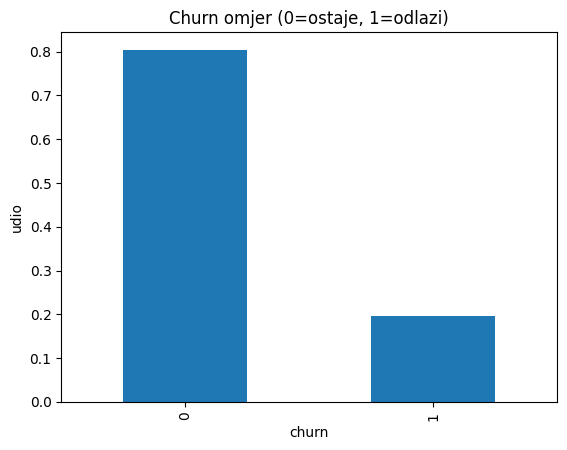

In [2]:
import matplotlib.pyplot as plt

df["churn"].value_counts(normalize=True).plot(kind="bar")
plt.title("Churn omjer (0=ostaje, 1=odlazi)")
plt.ylabel("udio")
plt.show()


Chart: Churn Rate by Contract Type

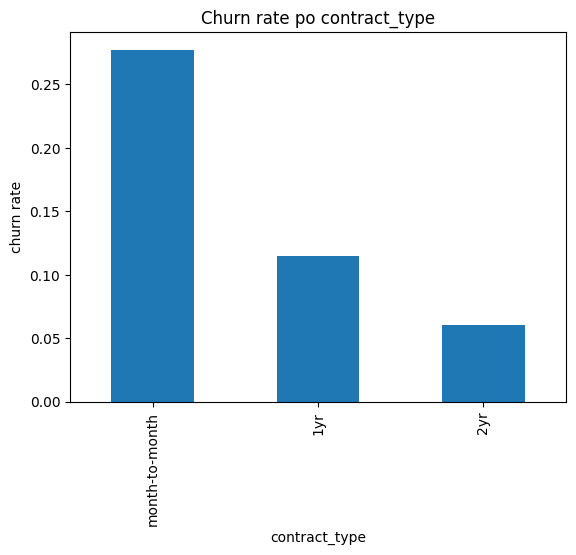

In [3]:
df.groupby("contract_type")["churn"].mean().sort_values(ascending=False).plot(kind="bar")
plt.title("Churn rate po contract_type")
plt.ylabel("churn rate")
plt.show()


Chart: Churn Rate by Payment Method

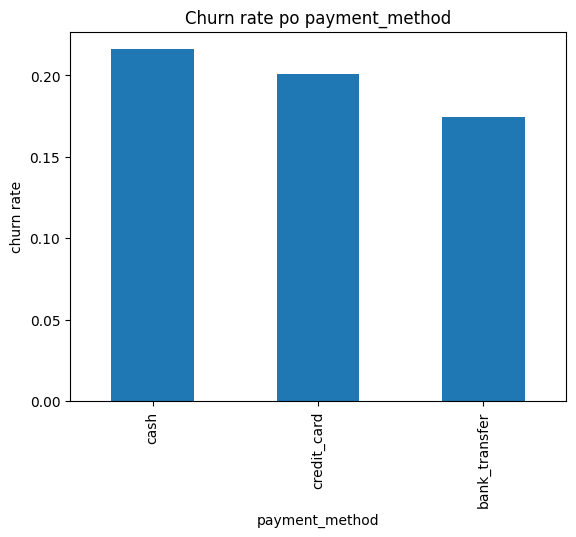

In [4]:
df.groupby("payment_method")["churn"].mean().sort_values(ascending=False).plot(kind="bar")
plt.title("Churn rate po payment_method")
plt.ylabel("churn rate")
plt.show()

Chart: Tenure by Churn

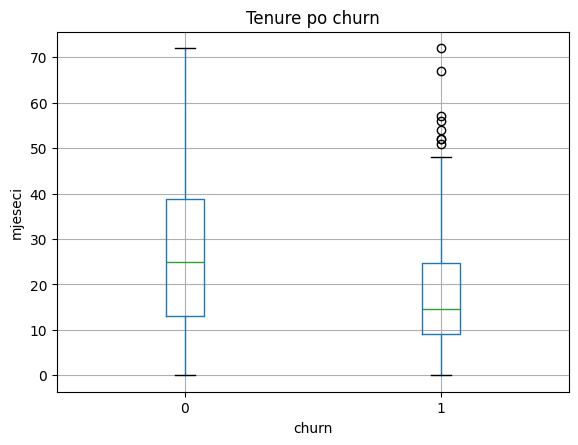

In [5]:
df.boxplot(column="tenure", by="churn")
plt.title("Tenure po churn")
plt.suptitle("")
plt.xlabel("churn")
plt.ylabel("mjeseci")
plt.show()


Chart: Last Login Days by Churn

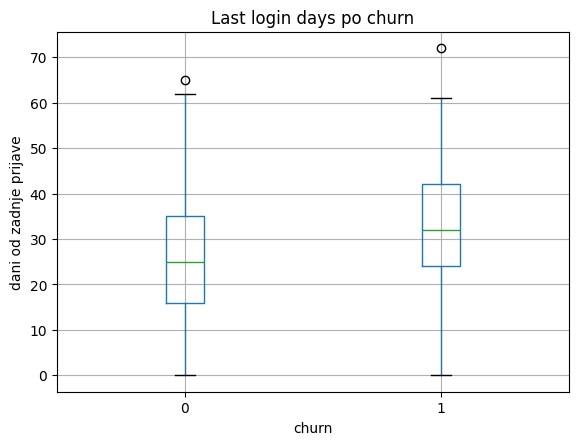

In [6]:
df.boxplot(column="last_login_days", by="churn")
plt.title("Last login days po churn")
plt.suptitle("")
plt.xlabel("churn")
plt.ylabel("dani od zadnje prijave")
plt.show()


### EDA Summary
- About 20% of customers churn, so churn is the minority class.
- Month-to-month contracts have the highest churn rate.
- Churn rate differs by payment method.
- Customers who churn usually have shorter tenure.
- Higher inactivity (more days since last login) is linked to higher churn.


## Feature Engineering & Preprocessing

Here we prepare the data for modeling by encoding categories
and scaling numerical features.


Train / Test Split

In [7]:
from sklearn.model_selection import train_test_split

target = "churn"
X = df.drop(columns=[target, "customer_id"])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)


(1120, 13) (280, 13)


Feature Engineering & Preprocessing

In [10]:
num_cols = [
    "tenure", "monthly_charges", "total_charges",
    "support_tickets", "last_login_days", "complaints"
]

cat_cols = [
    "contract_type", "payment_method", "promo_active",
    "auto_renew", "usage_level", "region", "customer_segment"
]


Preprocessing Pipeline

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)


Baseline Model: Logistic Regression

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

logreg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])


### Preprocessing & Model Setup Summary
- The data was split into training and test sets.
- Numerical features were scaled and categorical features were encoded.
- A preprocessing pipeline was used to prepare the data consistently.
- Logistic Regression was used as the baseline model.
- Class imbalance was handled during training.


## Model Training & Evaluation

In this section, we train a baseline model and evaluate its performance
using appropriate metrics for churn prediction.


Model Training

In [15]:
# Train the baseline model
logreg_model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

Predictions & Probabilities

In [16]:
# Class predictions (0/1)
y_pred = logreg_model.predict(X_test)

# Predicted probabilities for churn (class = 1)
y_proba = logreg_model.predict_proba(X_test)[:, 1]

y_pred[:10], y_proba[:10]


(array([1, 1, 1, 1, 0, 0, 0, 0, 0, 1]),
 array([0.82436791, 0.83342914, 0.6878871 , 0.75401821, 0.44272655,
        0.18543238, 0.37696323, 0.20458138, 0.34167281, 0.6260261 ]))

Evaluation Metrics

In [17]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("Precision:", round(precision, 3))
print("Recall:   ", round(recall, 3))
print("ROC-AUC:  ", round(roc_auc, 3))


Precision: 0.275
Recall:    0.6
ROC-AUC:   0.72


Confusion Matrix

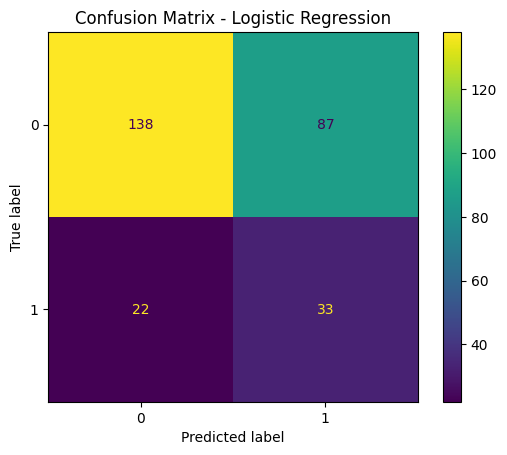

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


Threshold Tuning

In [19]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

thresholds = [0.3, 0.4, 0.5, 0.6]
for t in thresholds:
    pred_t = (y_proba >= t).astype(int)
    p = precision_score(y_test, pred_t)
    r = recall_score(y_test, pred_t)
    print(f"threshold={t}: precision={p:.3f}, recall={r:.3f}")


threshold=0.3: precision=0.252, recall=0.927
threshold=0.4: precision=0.263, recall=0.745
threshold=0.5: precision=0.275, recall=0.600
threshold=0.6: precision=0.354, recall=0.527


### Model Evaluation Summary

- The model achieves a ROC-AUC score of 0.72, indicating good overall ability
  to distinguish between churn and non-churn customers.

- Recall is relatively high, meaning the model successfully identifies
  a large portion of customers who actually churn.

- Precision is lower, which is expected in churn prediction problems
  where the positive class is a minority.

- Threshold analysis shows a clear trade-off between precision and recall.
  Lower thresholds capture more churners, while higher thresholds reduce
  false positives.

- This model is suitable for ranking customers by churn risk and supporting
  targeted retention actions.


## Probability-Based Churn Scoring

In this section, we rank customers by their predicted churn probability
to identify the most at-risk users

In [20]:
import pandas as pd

test_out = X_test.copy()
test_out["churn_true"] = y_test.values
test_out["churn_proba"] = y_proba

top10 = test_out.sort_values("churn_proba", ascending=False).head(int(0.10 * len(test_out)))
share_of_churn = top10["churn_true"].sum() / test_out["churn_true"].sum()

print("Top 10% users:", len(top10))
print("Share of total churn in top 10%:", round(share_of_churn, 3))
top10[["churn_proba", "churn_true"]].head(10)


Top 10% users: 28
Share of total churn in top 10%: 0.309


,churn_proba,churn_true
873,0.915077,0
1278,0.906562,1
310,0.838793,1
597,0.833429,0
892,0.824368,1
1344,0.824009,0
1004,0.814942,0
811,0.808247,1
297,0.804229,0
164,0.799417,1


### Churn Risk Scoring Summary
- Customers were ranked based on predicted churn probability.
- A small percentage of users accounts for a large share of total churn.
- This ranking allows the business to focus retention efforts
  on the most critical customers.


## Business Impact Simulation

In this section, we estimate the potential business value
of targeting high-risk customers.

In [21]:
avg_value = 120      # € per customer per year (example)
discount = 10        # € offer
save_rate = 0.25     # we save 25% of targeted churners

target = test_out.sort_values("churn_proba", ascending=False).head(int(0.20 * len(test_out)))
expected_churners = target["churn_proba"].sum()
saved_customers = expected_churners * save_rate

value_saved = saved_customers * avg_value
campaign_cost = len(target) * discount
net_impact = value_saved - campaign_cost

print("Targeted users (top 20%):", len(target))
print("Expected churners in target:", round(expected_churners, 1))
print("Saved customers:", round(saved_customers, 1))
print("Value saved (€):", round(value_saved, 0))
print("Campaign cost (€):", round(campaign_cost, 0))
print("Net impact (€):", round(net_impact, 0))


Targeted users (top 20%): 56
Expected churners in target: 41.8
Saved customers: 10.4
Value saved (€): 1253.0
Campaign cost (€): 560
Net impact (€): 693.0


### Business Impact Summary
- Targeting the highest-risk customers can significantly reduce churn.
- Even a simple retention action can lead to meaningful savings.
- This shows how the model can directly support business decisions.


## Feature Importance Analysis
In this section, we analyze which features have the strongest impact on churn predictions.


In [22]:
import pandas as pd
import numpy as np

feature_names = logreg_model.named_steps["preprocess"].get_feature_names_out()
coefs = logreg_model.named_steps["model"].coef_[0]

fi = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False)

fi.head(15)


,feature,coef,abs_coef
8,cat__contract_type_month-to-month,0.485743,0.485743
0,num__tenure,-0.482796,0.482796
7,cat__contract_type_2yr,-0.453097,0.453097
26,cat__customer_segment_premium,-0.391176,0.391176
15,cat__auto_renew_1,-0.300594,0.300594
13,cat__promo_active_1,-0.268051,0.268051
24,cat__customer_segment_business,0.242972,0.242972
23,cat__region_Zagreb,-0.232739,0.232739
6,cat__contract_type_1yr,-0.183942,0.183942
16,cat__usage_level_high,-0.179982,0.179982


### Feature Importance Summary
- Contract type, tenure, and customer activity are the most important factors for churn.
- Short-term contracts and low activity increase churn risk.
- These insights help explain why customers leave and support business decisions.


## Final Model 
In this section, we train the selected model on the full dataset
to prepare it for future use.


In [23]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

final_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

final_model.fit(X, y)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [24]:
import joblib

joblib.dump(final_model, "final_churn_model.joblib")


['final_churn_model.joblib']

### Final Model Summary
- The final model was trained on the full dataset.
- It is ready to score new customers and provide churn probabilities.
- The saved model can be reused without retraining.
